# Analysis testing notebook

Here we test and look on different methods to analyze the data

Use the conda environment as explained in the `setup_instruction.md` file

In [1]:
# imports
import pandas as pd
import numpy as np
import os
import volue_insight_timeseries
import matplotlib.pyplot as plt

# imports from the api_functions.py file
from api_functions import initialize_session, get_curve, select_data, plot_dataframe


### Small example

As you see we initialize the session, decide which curve to import and then get it and select the timeframe we want to analyze

Authentication succeeded. Session returned.
Curve fetched correctly! Curve ID: 20744, Type: TIME_SERIES
Selecting data from 2026-01-01 to 2026-01-10...
Retrieved 216 data points.
Plotting data...


/opt/anaconda3/envs/hackathon-energy/lib/python3.11/site-packages/volue_insight_timeseries/util.py:147: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return res.asfreq(self._map_freq(self.frequency))


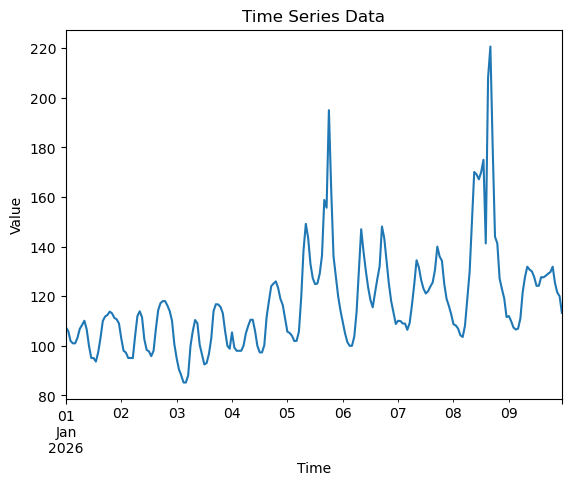

Plotting completed.


In [2]:

# initialize the session
session = initialize_session()

# define the curve name
curve_name = 'pri ch spot €/mwh cet h a'

# get the curve object
curve = get_curve(session, curve_name)
# select data
data_df = select_data(curve, data_from='2026-01-01', data_to='2026-01-10')
# print(data_df)

# plot the data
plot_dataframe(data_df)